In [161]:
!pip install transformers
!pip install accelerate
# TODO: check lr scheduler

In [162]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score as kappa
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import GPT2Tokenizer, GPT2Model
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import os
import time
import pathlib

# log folder to save log files
log_folder = '/content/drive/MyDrive/asap/'

# target column
target_column = "score"

# hyper parameters
hp = {
    "base_model": "gpt2",
    "lr": 1e-4,
    "num_epochs": 30,
    "batch_size":2,
    "use_amp": True,
    "mixed_precision": "fp16",
}

# Prepare ASAP Dataset

In [163]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
# Original kaggle training set
kaggle_dataset  = pd.read_csv('/content/drive/MyDrive/GPT-2 MODEL/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")

# Smaller training set used for this project
dataset_df = pd.DataFrame(
  {
    'essay_id' : kaggle_dataset['essay_id'],
    'essay_set' : kaggle_dataset['essay_set'],
    'essay' : kaggle_dataset['essay'],
    'rater1' : kaggle_dataset['rater1_domain1'],
    'rater2' : kaggle_dataset['rater2_domain1'],
    'rater3' : kaggle_dataset['rater3_domain1'],
    'score1' : kaggle_dataset['domain1_score']
  })
dataset_df.head()

,essay_id,essay_set,essay,rater1,rater2,rater3,score1
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8


## Use essay_set=8 for classification

In [178]:
essay_df = dataset_df[dataset_df['essay_set'] == 8].copy()
essay_df.shape

# essay_df = dataset_df.loc[(dataset_df['essay_set'] == 3) | (dataset_df['essay_set'] == 4) | (dataset_df['essay_set'] == 5) | (dataset_df['essay_set'] == 6)].copy()
# essay_df.shape

(723, 7)

In [179]:
# Calculate the new frequencies after the removal
new_frequencies = essay_df['score1'].value_counts().sort_index()

# Print the new frequencies
print(new_frequencies)


score1
10      1
15      1
20      4
21      2
22      1
24      3
25      5
26      4
27      6
28     11
29      8
30     49
31     34
32     37
33     32
34     39
35     47
36     65
37     39
38     20
39      8
40    161
41     22
42     23
43     15
44     14
45     31
46     13
47      7
48      3
49      2
50     13
55      2
60      1
Name: count, dtype: int64


In [180]:
import pandas as pd
from scipy import stats

# Assuming essay_df is already defined and contains the 'score1' column

# Handle missing values by dropping rows with missing values in the 'score1' column
essay_df.dropna(subset=["score1"], inplace=True)

# Identify and address outliers using Z-scores
z_scores = stats.zscore(essay_df["score1"])
essay_df = essay_df[(z_scores < 3) & (z_scores > -3)]

# Calculate the new frequencies after the removal
new_frequencies = essay_df['score1'].value_counts().sort_index()

# Print the new frequencies
print(new_frequencies)

score1
20      4
21      2
22      1
24      3
25      5
26      4
27      6
28     11
29      8
30     49
31     34
32     37
33     32
34     39
35     47
36     65
37     39
38     20
39      8
40    161
41     22
42     23
43     15
44     14
45     31
46     13
47      7
48      3
49      2
50     13
Name: count, dtype: int64


In [183]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler

# Assuming essay_df is already defined and contains the 'score2' column

# Standardize the data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(essay_df[['score1']])

# Define the bins and labels for score3
bins1 = [-float("inf"), -2, -1, 0, 1, 2, float("inf")]
labels = [1, 2, 3, 4, 5, 6]
essay_df['score3'] = pd.cut(standardized_values.flatten(), bins=bins1, labels=labels).astype(int)

# Define the bins and labels for score4
bins2 = [-float("inf"), -1.5, -0.5, 0, 0.5, 1.5, float("inf")]
essay_df['score4'] = pd.cut(standardized_values.flatten(), bins=bins2, labels=labels).astype(int)


# Define the bins and labels for score5
bins3 = [-float("inf"), -1.2, -0.7, -0.2, 0.3, 0.7, 1.3, float("inf")]
labels2 = [1, 2, 3, 4, 5, 6, 7]
essay_df['score5'] = pd.cut(standardized_values.flatten(), bins=bins3, labels=labels2).astype(int)

# Define the bins and labels for score5
bins4 = [-float("inf"), -1.2, -0.7, -0.3, 0.3, 1.2, float("inf")]
labels3 = [1, 2, 3, 4, 5, 6]
essay_df['score6'] = pd.cut(standardized_values.flatten(), bins=bins4, labels=labels3).astype(int)



# Check the class counts
print("Class counts for score3:")
print(essay_df['score3'].value_counts().sort_index())
print("\nClass counts for score4:")
print(essay_df['score4'].value_counts().sort_index())

# Define Cramer's V function
def cramerv(a, b):
    contingency = pd.crosstab(index=a, columns=b)
    chi2 = chi2_contingency(contingency)[0]
    n = np.sum(contingency.values)
    r, k = contingency.shape
    statistic = np.sqrt((chi2 / n) / min(r - 1, k - 1))
    return statistic

# Calculate Pearson, Spearman correlations, and Cramer's V for the pairs
pairs = [
    ('score1', 'score3'),
    ('score1', 'score4'),
    ('score3', 'score4'),
    ('score1', 'score5'),
    ('score1', 'score6')
]

for pair in pairs:
    x = essay_df[pair[0]]
    y = essay_df[pair[1]]

    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    cramer_v = cramerv(x, y)

    print(f"\nCorrelations for {pair[0]} and {pair[1]}:")
    print(f"Pearson correlation: {pearson_corr}")
    print(f"Spearman correlation: {spearman_corr}")
    print(f"Cramer's V: {cramer_v}")


Class counts for score3:
score3
1     15
2    112
3    220
4    273
5     80
6     18
Name: count, dtype: int64

Class counts for score4:
score4
1     36
2    199
3    112
4     67
5    266
6     38
Name: count, dtype: int64

Correlations for score1 and score3:
Pearson correlation: 0.9663188763385168
Spearman correlation: 0.9609881800875097
Cramer's V: 1.0

Correlations for score1 and score4:
Pearson correlation: 0.9409444297192125
Spearman correlation: 0.9672536524886071
Cramer's V: 1.0

Correlations for score3 and score4:
Pearson correlation: 0.905472485640042
Spearman correlation: 0.9254548591955619
Cramer's V: 0.6748823871179708

Correlations for score1 and score5:
Pearson correlation: 0.9676055675046464
Spearman correlation: 0.9931091416684085
Cramer's V: 1.0

Correlations for score1 and score6:
Pearson correlation: 0.9529195000274331
Spearman correlation: 0.9833822942259642
Cramer's V: 1.0


In [182]:

# Define the bins and labels for score5
bins4 = [-float("inf"), -1.2, -0.7, -0.3, 0.3, 1.2, float("inf")]
labels3 = [1, 2, 3, 4, 5, 6]
essay_df['score6'] = pd.cut(essay_df['score1'], bins=bins4, labels=labels3).astype(int)

# Check the class counts
print("Class counts for score6:")
print(essay_df['score6'].value_counts().sort_index())

Class counts for score6:
score6
6    718
Name: count, dtype: int64


In [95]:
print(essay_df)

       essay_id  essay_set                                              essay  \
12253     20716          8   A long time ago when I was in third grade I h...   
12254     20717          8   Softball has to be one of the single most gre...   
12255     20718          8   Some people like making people laugh, I love ...   
12256     20719          8   "LAUGHTER"  @CAPS1 I hang out with my friends...   
12257     20721          8  Well ima tell a story about the time i got @CA...   
...         ...        ...                                                ...   
12971     21626          8   In most stories mothers and daughters are eit...   
12972     21628          8   I never understood the meaning laughter is th...   
12973     21629          8  When you laugh, is @CAPS5 out of habit, or is ...   
12974     21630          8                                 Trippin' on fen...   
12975     21633          8   Many people believe that laughter can improve...   

       rater1  rater2  rate

In [146]:
# 6'dan düşük skorları 6'ya yükseltme
essay_df['score2'] = essay_df['score1'].apply(lambda x: 29 if x < 29 else x)
# Yeni frekansları hesaplama
new_frequencies = essay_df['score2'].value_counts().sort_index()

# 6'dan düşük skorları 6'ya yükseltme
essay_df['score2'] = essay_df['score2'].apply(lambda x: 38 if x == 39 else x)
# Yeni frekansları hesaplama
# Assuming 'score1' is the column with the scores
# Replace score 55 with 50, and any score less than 6 with 60

essay_df['score2'] = essay_df['score2'].apply(lambda x: 50 if x == 60 else x)

import pandas as pd

# Assuming 'essay_df' is your DataFrame and 'score1' is the column of interest

# Filter the DataFrame to exclude rows where 'score1' is 47, 48, or 60
filtered_df = essay_df[~essay_df['score2'].isin([47, 48, 49, 55, 60])]

# If you want to update 'essay_df' directly and use it further, just overwrite it:
essay_df = filtered_df.copy()

# Calculate the new frequencies after the removal
new_frequencies = essay_df['score2'].value_counts().sort_index()

# Print the new frequencies
print(new_frequencies)


score2
29     40
30     49
31     34
32     37
33     32
34     39
35     47
36     65
37     39
38     28
40    161
41     22
42     23
43     15
44     14
45     31
46     13
50     13
Name: count, dtype: int64


<ipython-input-146-4364a296d9b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_df['score2'] = essay_df['score1'].apply(lambda x: 29 if x < 29 else x)
<ipython-input-146-4364a296d9b9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_df['score2'] = essay_df['score2'].apply(lambda x: 38 if x == 39 else x)
<ipython-input-146-4364a296d9b9>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [97]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming essay_df is already defined and contains the 'score2' column

# Standardize the data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(essay_df[['score2']])

# Define the bins for 6 classes: [-inf, -2, -1, 0, 1, 2, inf]
bins = [-float("inf"), -2, -1, 0, 1, 2, float("inf")]
labels = [1, 2, 3, 4, 5, 6]

# Assign the standardized values to 6 classes
essay_df['score3'] = pd.cut(standardized_values.flatten(), bins=bins, labels=labels).astype(int)

# Check the class counts
class_counts = essay_df['score3'].value_counts().sort_index()
print(class_counts)



score3
2    129
3    220
4    250
5     96
6     14
Name: count, dtype: int64


In [99]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming essay_df is already defined and contains the 'score2' column

# Standardize the data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(essay_df[['score1']])

# Adjust the bins for a more balanced distribution
# These bin ranges are just an example and may need to be adjusted based on your data distribution
bins = [-float("inf"), -1.5, -0.5, 0, 0.5, 1.5, float("inf")]
labels = [1, 2, 3, 4, 5, 6]

# Assign the standardized values to 6 classes
essay_df['score4'] = pd.cut(standardized_values.flatten(), bins=bins, labels=labels).astype(int)

# Check the class counts
class_counts = essay_df['score4'].value_counts().sort_index()
print(class_counts)


score4
1     38
2    160
3    151
4     67
5    266
6     27
Name: count, dtype: int64


Class counts for score3:
score3
1     13
2    108
3    259
4    234
5     80
6     18
Name: count, dtype: int64

Class counts for score4:
score4
1     38
2    191
3    151
4     28
5    235
6     69
Name: count, dtype: int64

Correlations for score1 and score3:
Pearson correlation: 0.9694022457169894
Spearman correlation: 0.9613533618590079
Cramer's V: 1.0

Correlations for score1 and score4:
Pearson correlation: 0.9529061025874114
Spearman correlation: 0.9732212742715285
Cramer's V: 1.0

Correlations for score3 and score4:
Pearson correlation: 0.9173778865419316
Spearman correlation: 0.9401091642706578
Cramer's V: 0.6804875004500343

Correlations for score1 and score5:
Pearson correlation: 0.9740089311187163
Spearman correlation: 0.9914949801866431
Cramer's V: 1.0

Correlations for score1 and score6:
Pearson correlation: nan
Spearman correlation: nan
Cramer's V: nan


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
<ipython-input-177-27cf5f532a77>:46: RuntimeWarning: invalid value encountered in scalar divide
  statistic = np.sqrt((chi2 / n) / min(r - 1, k - 1))


In [35]:
# Calculate Pearson, Spearman correlations, and Cramer's V for the pairs
pairs = [
    ('score2', 'score3'),
    ('score2', 'score4'),
    ('score3', 'score4')
]

for pair in pairs:
    x = essay_df[pair[0]]
    y = essay_df[pair[1]]

    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    cramer_v = cramerv(x, y)

    print(f"\nCorrelations for {pair[0]} and {pair[1]}:")
    print(f"Pearson correlation: {pearson_corr}")
    print(f"Spearman correlation: {spearman_corr}")
    print(f"Cramer's V: {cramer_v}")


Correlations for score2 and score3:
Pearson correlation: 0.9665637918052551
Spearman correlation: 0.9649228227220767
Cramer's V: 1.0

Correlations for score2 and score4:
Pearson correlation: 0.9583391551248408
Spearman correlation: 0.9757231834128445
Cramer's V: 1.0

Correlations for score3 and score4:
Pearson correlation: 0.9166474165979499
Spearman correlation: 0.9300770615198466
Cramer's V: 0.7017520384916566


In [160]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler

# Assuming essay_df is already defined and contains the 'score2' column

# Standardize the data
scaler = StandardScaler()
#standardized_values = scaler.fit_transform(essay_df[['score2']])
#standardized_values =essay_df['score2']
# Define the bins and labels for score3
bins1 = [-float("inf"), -1.5, -1, 0, 1.2, 2, float("inf")]
labels = [1, 2, 3, 4, 5, 6]
essay_df['score3'] = pd.cut(essay_df['score1'], bins=bins1, labels=labels).astype(int)

# Define the bins and labels for score5
bins3 = [-float("inf"), -1.2, -0.7, -0.2, 0.3, 0.7, 1.3, float("inf")]
labels2 = [1, 2, 3, 4, 5, 6, 7]
essay_df['score5'] = pd.cut(essay_df['score1'], bins=bins3, labels=labels2).astype(int)


# Define the bins and labels for score5
bins4 = [-float("inf"), -1.2, -0.7, -0.2, 0.3, 1.2, float("inf")]
labels3 = [1, 2, 3, 4, 5, 6]
essay_df['score5'] = pd.cut(essay_df['score1'], bins=bins3, labels=labels2).astype(int)


# Check the class counts
print("Class counts for score6:")
print(essay_df['score6'].value_counts().sort_index())

# Check the class counts
print("Class counts for score3:")
print(essay_df['score3'].value_counts().sort_index())
print("\nClass counts for score4:")
print(essay_df['score4'].value_counts().sort_index())
print("\nClass counts for score5:")
print(essay_df['score5'].value_counts().sort_index())

# Define Cramer's V function
def cramerv(a, b):
    contingency = pd.crosstab(index=a, columns=b)
    chi2 = chi2_contingency(contingency)[0]
    n = np.sum(contingency.values)
    r, k = contingency.shape
    statistic = np.sqrt((chi2 / n) / min(r - 1, k - 1))
    return statistic

# Function to calculate chi-square
def chi_square_test(a, b):
    contingency = pd.crosstab(index=a, columns=b)
    stat, p, dof, expected = chi2_contingency(contingency)
    return p

# Calculate Pearson, Spearman correlations, and Chi-square for the pairs
pairs = [
    ('score1', 'score3'),
    ('score1', 'score4'),
    ('score3', 'score4'),
    ('score1', 'score5'),
    ('score3', 'score5'),
    ('score4', 'score5'),
    ('score1', 'score6')
    ]

for pair in pairs:
    x = essay_df[pair[0]]
    y = essay_df[pair[1]]

    pearson_corr, _ = pearsonr(x, y)
    spearman_corr, _ = spearmanr(x, y)
    cramer_v = cramerv(x, y)
    chi_square_p = chi_square_test(x, y)

    print(f"\nCorrelations for {pair[0]} and {pair[1]}:")
    print(f"Pearson correlation: {pearson_corr}")
    print(f"Spearman correlation: {spearman_corr}")
    print(f"Cramer's V: {cramer_v}")
    print(f"Chi-square test p-value: {chi_square_p}")
    alpha = 0.05
    if chi_square_p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')


ValueError: Bin labels must be one fewer than the number of bin edges

In [175]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Assuming essay_df is already defined and contains the 'score1' and 'score2' columns

# Identify and address outliers using Z-scores
z_scores = stats.zscore(essay_df["score1"])
essay_df = essay_df[(z_scores < 3) & (z_scores > -3)]

# Standardize the data
scaler = StandardScaler()
essay_df['standardized_score1'] = scaler.fit_transform(essay_df[['score1']])

# Define the bins and labels for score6
bins4 = [-float("inf"), -1.2, -0.7, -0.3, 0.3, 0.7, float("inf")]
labels3 = [1, 2, 3, 4, 5, 6]

# Ensure standardized_score1 is converted to a numpy array and flattened properly
standardized_scores = essay_df['standardized_score1'].values.ravel()

# Categorize the standardized scores into bins
essay_df['score6'] = pd.cut(standardized_scores, bins=bins4, labels=labels3).astype(int)

# Check the class counts
print("Class counts for score6:")
print(essay_df['score6'].value_counts().sort_index())


Class counts for score6:
score6
1     87
2    103
3     86
4    124
5    169
6    143
Name: count, dtype: int64


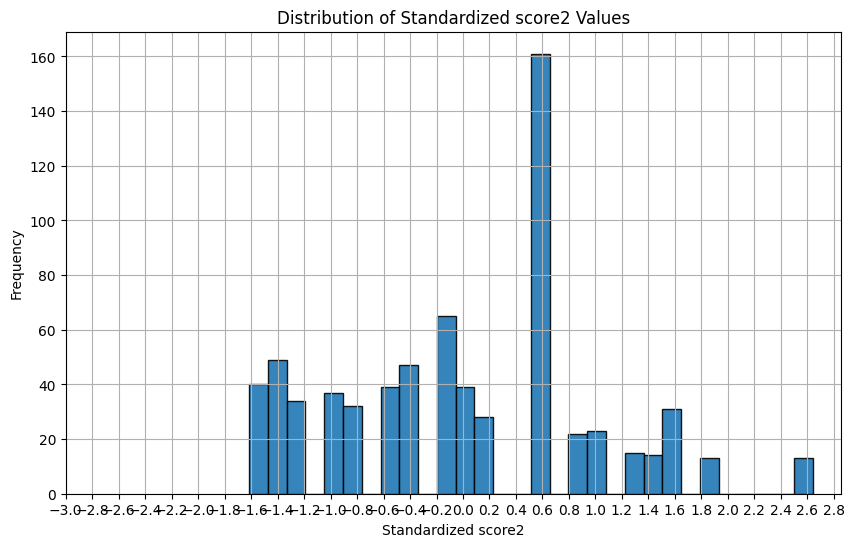

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Assuming essay_df is already defined and contains the 'score2' column

# Standardize the data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(essay_df[['score2']])

# Plot the distribution of the standardized values with more detailed x-axis ticks
plt.figure(figsize=(10, 6))
plt.hist(standardized_values, bins=30, edgecolor='k', alpha=0.9)
plt.title('Distribution of Standardized score2 Values')
plt.xlabel('Standardized score2')
plt.ylabel('Frequency')
plt.xticks(np.arange(-3, 3, 0.2))  # Set x-ticks at intervals of 0.1
plt.grid(True)
plt.show()
essay_df['score4'] = pd.cut(essay_df['score1'], bins=bins2, labels=labels).astype(int)





In [9]:
from sklearn.preprocessing import StandardScaler
essay_df['target_score'] = essay_df[target_column] #- essay_df[target_column].min()

#Standardize the data
scaler = StandardScaler()
essay_df[['score']] = scaler.fit_transform(essay_df[['score']])


In [10]:
from sklearn.model_selection import train_test_split

essay_df['target_score'] = essay_df[target_column] - essay_df[target_column].min()

X, y = essay_df['essay'].to_list(), essay_df['target_score'].to_numpy()
num_labels = essay_df[target_column].unique().size

# 60 / 40 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42) # stratify=y, this paramter will not work if any class has number of examples lower than 2

# split test to half to get 60 / 20 / 20 split

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42) # stratify=y_test

In [11]:
import torch
from torch.utils.data import Dataset

class EssayDataset(Dataset):
    def __init__(self, essays, targets, tokenizer, device):
        self.essays = essays
        self.targets = targets
        self.tokenizer = tokenizer
        self.device = device

    def __len__(self):
        return len(self.essays)

    def __getitem__(self, idx):
        text = str(self.essays[idx])
        # Ensure that the tokenizer and device are used correctly
        encoded_input = self.tokenizer(text, truncation=True, return_tensors='pt')
        encoded_input = {key: val.to(self.device) for key, val in encoded_input.items()}

        # It's better to ensure the target is a tensor and on the correct device
        target = torch.tensor(self.targets[idx], dtype=torch.long).to(self.device)

        return encoded_input['input_ids'].squeeze(), encoded_input['attention_mask'].squeeze(), target


In [12]:
# collater function to pad tokens
def collate_fn(batch):
    PAD_TOKEN_ID = 50256 # Use tokenizer.pad_token_id to check
    input_ids_list, attention_mask_list, targets = [], [], []

    for input_ids, attention_mask, target in batch:
        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        targets.append(target)

    # Pad the batch to the maximum sequence length within that batch using the tokenizer's pad token
    max_length = max(len(ids) for ids in input_ids_list)
    padded_input_ids = []
    padded_attention_mask = []

    for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
        pad_length = max_length - len(input_ids)
        padded_input_ids.append(torch.cat([input_ids, torch.tensor([PAD_TOKEN_ID] * pad_length, device=device, dtype=torch.long)]))
        # add zeros to attention mask for padds
        padded_attention_mask.append(torch.cat([attention_mask, torch.zeros(pad_length, dtype=torch.long, device=device)]))

    return torch.stack(padded_input_ids), torch.stack(padded_attention_mask), torch.tensor(targets)

In [13]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained(hp['base_model'])
tokenizer.pad_token_id = tokenizer.eos_token_id

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [14]:
from transformers import GPT2ForSequenceClassification

class ClassifierLayer(torch.nn.Module):

  def __init__(self, input_size, output_size, bias=False):
    super(ClassifierLayer, self).__init__()

    self.dropout = torch.nn.Dropout(0.1)
    self.linear = torch.nn.Linear(input_size, output_size, bias=bias)

  def forward(self, x):
    inputs = self.dropout(x)
    return self.linear(inputs)

class GPT2Classification(GPT2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.score = ClassifierLayer(config.n_embd, self.num_labels, bias=False)

        self.post_init()

In [15]:
from accelerate import Accelerator

# use fp16 mixed precision to improve training speed
accelerator = Accelerator(mixed_precision=hp['mixed_precision']) # fp16
device = accelerator.device

model = GPT2Classification.from_pretrained(hp['base_model'], num_labels=num_labels)
#model = GPT2ForSequenceClassification.from_pretrained(hp['base_model'], num_labels=num_labels)
model.to(device)
tokenizer.pad_token_id = tokenizer.eos_token_id
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2Classification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.linear.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from sklearn.metrics import classification_report
# train loop

def train_loop(model, train_loader, val_loader, loss_fct, optimizer, lr_scheduler, progress_bar, log_file_handler, logging_step=1, use_amp=False):
    samples = 0.
    cumulative_loss = 0.

    # set model to train mode
    model.train()

    for step, (inputs, attention_masks, targets) in enumerate(train_loader):
        targets = targets.reshape(-1, 1).to(device)
        attention_masks = attention_masks.to(device)
        outputs = model(inputs, attention_mask=attention_masks)
        loss = loss_fct(outputs["logits"].view(-1, model.num_labels), targets.view(-1))
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        samples += inputs.shape[0]
        cumulative_loss += loss.item()

        if step % logging_step == 0:
            # calculate cls_report on test set

            with torch.no_grad():
                test_loss, test_preds, cls_report = test_loop(model, val_loader, loss_fct, use_amp=use_amp)
            model.train()
            log_str = "Step: {:<6} \t Train loss: {:<6.4f} \t Validation loss: {:<6.4f}".format(step, (cumulative_loss/samples), test_loss)
            # Adding f1 accuracy recall prec metics
            log_str += "\n" + cls_report
            print(log_str)
            log_file_handler.write(log_str + "\n")
            samples = 0
            cumulative_loss = 0

    return cumulative_loss/samples if samples != 0 else float("inf")

def test_loop(model, test_loader, loss_fct, use_amp=False, show_progression=False):
    samples = 0.
    cumulative_loss = 0.
    preds = []
    labels = []

    # set model to eval mode
    model.eval()

    loop_iterator = enumerate(tqdm(test_loader)) if show_progression else enumerate(test_loader)

    with torch.no_grad():
        for step, (inputs, attention_masks, targets) in loop_iterator:
            targets = targets.reshape(-1, 1).to(device)
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs, attention_mask=attention_masks)
            loss = loss_fct(outputs["logits"].view(-1, model.num_labels), targets.view(-1))

            samples += inputs.shape[0]
            cumulative_loss += loss.item()

            probs = outputs['logits'].softmax(-1) # probs
            predictions = probs.argmax(-1) # predicted classes

            labels.extend(targets.tolist())
            preds.extend(predictions.tolist())

        cls_report = classification_report(labels, preds, zero_division=0)

    return cumulative_loss/samples if samples != 0 else float("inf"), np.asarray(preds, dtype=np.float32), cls_report



In [17]:
from tqdm.auto  import tqdm
from transformers import get_scheduler
from torch.optim import AdamW
from sklearn.utils import class_weight

lr = hp['lr']
num_epochs = hp['num_epochs']
batch_size = hp['batch_size']
use_amp = hp['use_amp']

# Assuming that 'accelerator' is already imported and initialized
device = accelerator.device  # Using the device associated with the accelerator

# Assuming that X_train, y_train, tokenizer are already defined and properly set up
# Create training dataset and DataLoader
train_dataset = EssayDataset(X_train, y_train, tokenizer, device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
num_training_steps = num_epochs * len(train_loader)

# create test data loader
test_dataset = EssayDataset(X_test, y_test, tokenizer, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# create val data loader
val_dataset = EssayDataset(X_val, y_val, tokenizer, device)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# # get class weights
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fct = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=lr)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer,
    num_warmup_steps=0, num_training_steps=num_training_steps
)
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# use accelerator prepare

# removed val_loader from prepare command
model, optimizer, train_loader, test_loader, val_loader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_loader, test_loader, val_loader, lr_scheduler
)

In [18]:
def open_log_file(log_folder, essay_df, model, label_column: str, hyper_parameters):
    # using time as a file name for logging

    timestr = time.strftime("%Y%m%d-%H%M%S")
    file_name = timestr + '.log'

    # check if folder exists, create if it isn't
    pathlib.Path(log_folder).mkdir(exist_ok=True, parents=True)

    # open file to log results
    log_file = os.path.join(log_folder, file_name)
    fp = open(log_file, "a")

    fp.write("Log time: " + timestr + "\n")
    fp.write("Essay classes: " + str(essay_df['essay_set'].unique()) + "\n")
    fp.write("Using score column: " + label_column + "\n")
    fp.write("Score distribution: " + "\n" + essay_df[label_column].value_counts().to_string() + "\n")

    fp.write("\n--- Model parameters:\n")
    fp.write(str(model))
    fp.write('\n')

    fp.write("\n--- Hyper parameters:\n")
    for k, v in hyper_parameters.items():
        fp.write(f" {k:<25}: {v}\n")

    fp.write('\n')
    fp.flush()
    return fp


In [ ]:
!nvidia-smi


Sun Oct  8 07:28:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    51W / 400W |   1599MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
import torch
print(torch.cuda.is_available())


True


In [ ]:
# Start logging to a file
fp = open_log_file(log_folder, essay_df, model, label_column=target_column, hyper_parameters=hp)

try:
    # Start training
    progress_bar = tqdm(range(num_training_steps))

    model.train()
    with accelerator.autocast():
        fp.write("Training logs: \n\n")
        for epoch in range(num_epochs):
            train_loss = train_loop(model, train_loader, val_loader, loss_fct, optimizer, lr_scheduler, progress_bar, fp, logging_step=len(train_loader)//3, use_amp=hp['use_amp'])
            with torch.no_grad():
                test_loss, test_preds, cls_report = test_loop(model, test_loader, loss_fct)
                log_string = "Epoch: {:<6}\t Test  loss: {:<6.4f}".format(epoch+1, test_loss)
                log_string += "\n" + cls_report
                print(log_string)
                fp.write(log_string + "\n")
finally:
    print("Log file closed.")
    fp.close()

  0%|          | 0/6390 [00:00<?, ?it/s]

Step: 0      	 Train loss: 7.8581 	 Validation loss: 7.0958
              precision    recall  f1-score   support

           0       0.67      0.05      0.09        42
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         0

    accuracy                           0.01       142
   macro avg       0.11      0.01      0.01       142
weighted avg       0.20      0.01      0.03       142

Step: 71     	 Train loss: 4.5077 	 Validation loss: 1.9608
              precision    recall  f1-score   support

           0       0.32      0.48      0.38        42
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        45
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         5
           6